In [1]:
import numpy as np
import os
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hdbscan
from scipy.linalg import eig

In [2]:
def load_noisy_model(model_name, noise_level=1, num_points=30000):
    dir_name = f"noised_point_clouds_{noise_level}%noise_{num_points}pts"
    points = np.loadtxt(f"{dir_name}/noised_{model_name}.xyz")[:, :3]
    labels = np.loadtxt(f"{dir_name}/labels_{model_name}.txt").flatten()
    return points, labels

In [11]:
def extract_features(points, k=20):
    n_points = points.shape[0]
    
    nbrs = NearestNeighbors(n_neighbors=k).fit(points)
    distances, indices = nbrs.kneighbors(points) 
    local_mean_dist = distances.mean(axis=1)
    local_std_dist = distances.std(axis=1)
    dist_kth_neighbor = distances[:, -1]
    local_spikiness = distances[:, -1] - distances[:, 0]
  
    log_density = np.log(local_mean_dist + 1e-6) 

  
    normals = np.zeros((n_points, 3))
    eigenvalues = np.zeros((n_points, 3)) 
    
    for i in range(n_points):
       
        neighbor_points = points[indices[i]]

       
        centroid = np.mean(neighbor_points, axis=0)
        centered_neighbors = neighbor_points - centroid

       
        if centered_neighbors.shape[0] < 2: 
            normals[i, :] = [0, 0, 1] 
            eigenvalues[i, :] = [0, 0, 0] 
            continue

        cov_matrix = np.cov(centered_neighbors, rowvar=False) 

       
        try:
            vals, vecs = eig(cov_matrix)
            vals = np.real(vals) 
            
           
            sort_indices = np.argsort(vals)[::-1] 
            sorted_vals = vals[sort_indices]
            sorted_vecs = vecs[:, sort_indices]

            eigenvalues[i, :] = sorted_vals

            normals[i, :] = sorted_vecs[:, 2] 
            
           
            if normals[i, 2] < 0:
                normals[i, :] *= -1

        except Exception as e:
            print(f"Warning: Eigenvalue decomposition failed for point {i}: {e}. Setting features to default.")
            normals[i, :] = [0, 0, 1]
            eigenvalues[i, :] = [0, 0, 0]

   
    lambda_sum = np.sum(eigenvalues, axis=1) + 1e-6 

    eigen_sum_features = eigenvalues 
    
 
    linearity = (eigenvalues[:, 0] - eigenvalues[:, 1]) / eigenvalues[:, 0]
    linearity[np.isnan(linearity)] = 0

    planarity = (eigenvalues[:, 1] - eigenvalues[:, 2]) / eigenvalues[:, 0]
    planarity[np.isnan(planarity)] = 0 

    sphericity = eigenvalues[:, 2] / eigenvalues[:, 0]
    sphericity[np.isnan(sphericity)] = 0 

    features = np.column_stack([
        points,                 # 3D coordinates
        local_mean_dist,        # Local density
        local_std_dist,         # Density variation
        dist_kth_neighbor,      # Distance to k-th neighbor
        local_spikiness,        # Local spikiness
        log_density,            # Log density

        normals,                # x,y,z components of normal vector (3 features)
        eigen_sum_features,     # Lambda0, Lambda1, Lambda2 (3 features)
        linearity,              # Local linearity
        planarity,              # Local planarity
        sphericity              # Local sphericity
    ])
    
    
    return StandardScaler().fit_transform(features)

In [12]:
def detect_noise_b_hdbscan(points, true_labels=None, use_pca=False, k_neighbors_for_features=20):
    features = extract_features(points, k=k_neighbors_for_features)
    
    if use_pca:
        pca = PCA(n_components=0.95) 
        features = pca.fit_transform(features)
        print(f"Reduced to {features.shape[1]} PCA components")
    
    
    min_cluster_size_values = range(2, 16, 1) 

    best_ari = -1
    best_precision = -1
    best_recall = -1
    best_f1 = -1
    best_params = {}
    best_labels = None
    
    results = []

    print(f"\nStarting HDBSCAN parameter optimization for k={k_neighbors_for_features}...")
    
    for min_size in min_cluster_size_values:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size, gen_min_span_tree=True)
        labels = clusterer.fit_predict(features)
        
        binary_labels = np.where(labels == -1, 1, 0)
        
        if true_labels is not None and len(np.unique(true_labels)) > 1 and len(np.unique(binary_labels)) > 1:
            ari = adjusted_rand_score(true_labels, binary_labels)
            
            try:
                prec = precision_score(true_labels, binary_labels, pos_label=1, zero_division=0)
                rec = recall_score(true_labels, binary_labels, pos_label=1, zero_division=0)
                f1 = f1_score(true_labels, binary_labels, pos_label=1, zero_division=0)
            except ValueError: 
                prec, rec, f1 = 0, 0, 0
            
            results.append({
                'min_cluster_size': min_size,
                'ari': ari,
                'precision': prec,
                'recall': rec,
                'f1_score': f1,
                'pred_labels': binary_labels 
            })

            if ari > best_ari:
                best_ari = ari
                best_params = {'min_cluster_size': min_size}
                best_labels = binary_labels
                best_precision = prec
                best_recall = rec
                best_f1 = f1
        
        elif true_labels is None:
            best_labels = binary_labels
            best_params = {'min_cluster_size': min_size}
            best_ari = -1 
            best_precision, best_recall, best_f1 = -1, -1, -1
            
    print(f"Optimization complete for k={k_neighbors_for_features}.")

    if best_labels is None and results:
        for res in results:
            if len(np.unique(res['pred_labels'])) > 1:
                best_labels = res['pred_labels']
                best_params = {'min_cluster_size': res['min_cluster_size']}
                best_ari = res['ari']
                best_precision = res['precision']
                best_recall = res['recall']
                best_f1 = res['f1_score']
                break
        if best_labels is None:
            best_labels = np.ones(len(points), dtype=int) 
            best_params = {'min_cluster_size': 0} 
            best_ari = 0.0
            best_precision, best_recall, best_f1 = 0.0, 0.0, 0.0
    elif best_labels is None: 
        best_labels = np.ones(len(points), dtype=int)
        best_params = {'min_cluster_size': 0}
        best_ari = 0.0
        best_precision, best_recall, best_f1 = 0.0, 0.0, 0.0

    other_metrics = {
        'precision_noise': best_precision,
        'recall_noise': best_recall,
        'f1_score_noise': best_f1
    }
    
    return best_labels, best_params, best_ari, other_metrics


In [14]:
def detect_noise_b_hdbscan_no_opt(points, true_labels=None, use_pca=False, 
                                 k_neighbors_for_features=10, 
                                 hdbscan_min_cluster_size=3): 
    
    
    print(f"\n--- Running HDBSCAN with fixed parameters ---")
    print(f"  Feature Extraction k: {k_neighbors_for_features}")
    print(f"  HDBSCAN min_cluster_size: {hdbscan_min_cluster_size}")
    print(f"  PCA Used: {use_pca}")

    features = extract_features(points, k=k_neighbors_for_features)
    
    if use_pca:
        pca = PCA(n_components=0.95)
        features = pca.fit_transform(features)
        print(f"  Reduced to {features.shape[1]} PCA components")
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=hdbscan_min_cluster_size, gen_min_span_tree=True)
    labels = clusterer.fit_predict(features)
    
    predicted_labels = np.where(labels == -1, 1, 0) 
    current_ari = 0.0
    current_precision = 0.0
    current_recall = 0.0
    current_f1 = 0.0
    
    if true_labels is not None and len(np.unique(true_labels)) > 1 and len(np.unique(predicted_labels)) > 1:
        current_ari = adjusted_rand_score(true_labels, predicted_labels)
        try:
            current_precision = precision_score(true_labels, predicted_labels, pos_label=1, zero_division=0)
            current_recall = recall_score(true_labels, predicted_labels, pos_label=1, zero_division=0)
            current_f1 = f1_score(true_labels, predicted_labels, pos_label=1, zero_division=0)
        except ValueError: 
            pass 
    applied_params = {
        'min_cluster_size': hdbscan_min_cluster_size,
        'k_features': k_neighbors_for_features,
        'use_pca': use_pca
    }

    other_metrics = {
        'precision_noise': current_precision,
        'recall_noise': current_recall,
        'f1_score_noise': current_f1
    }
    
    return predicted_labels, applied_params, current_ari, other_metrics

In [15]:
def plot_results(points, labels, title=""):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(points[:,0], points[:,1], points[:,2], 
                   c=labels, cmap='cool', s=1, alpha=0.6)
    plt.colorbar(sc, ticks=[0, 1], label='Noise (1) / Original (0)')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


--- Running HDBSCAN with fixed parameters ---
  Feature Extraction k: 10
  HDBSCAN min_cluster_size: 3
  PCA Used: False


C:\Users\daneb\AppData\Local\Temp\ipykernel_20368\3417348108.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  normals[i, :] = sorted_vecs[:, 2]
C:\Users\daneb\AppData\Local\Temp\ipykernel_20368\3417348108.py:62: RuntimeWarning: invalid value encountered in divide
  linearity = (eigenvalues[:, 0] - eigenvalues[:, 1]) / eigenvalues[:, 0]
C:\Users\daneb\AppData\Local\Temp\ipykernel_20368\3417348108.py:65: RuntimeWarning: invalid value encountered in divide
  planarity = (eigenvalues[:, 1] - eigenvalues[:, 2]) / eigenvalues[:, 0]
C:\Users\daneb\AppData\Local\Temp\ipykernel_20368\3417348108.py:68: RuntimeWarning: invalid value encountered in divide
  sphericity = eigenvalues[:, 2] / eigenvalues[:, 0]



Model: duck (HDBSCAN Optimized - Fixed Params)
Applied Params: {'min_cluster_size': 3, 'k_features': 10, 'use_pca': False}
ARI Score: 0.298
Noise Precision: 0.807
Noise Recall: 0.717
Noise F1-Score: 0.759


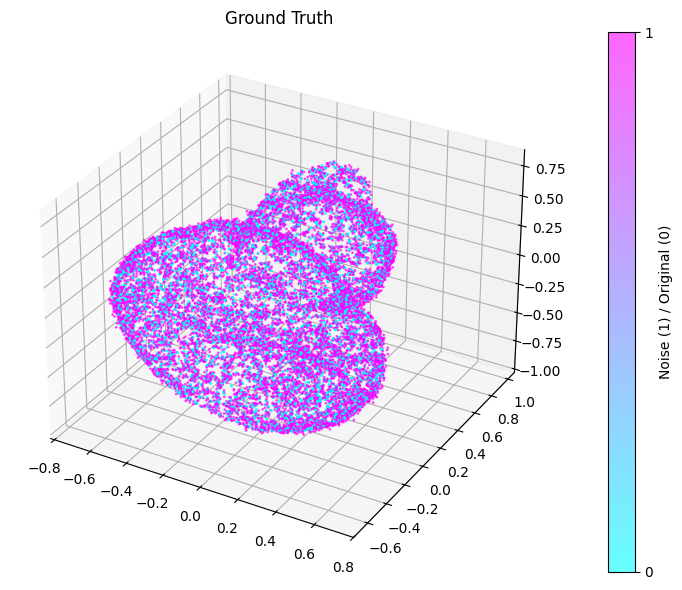

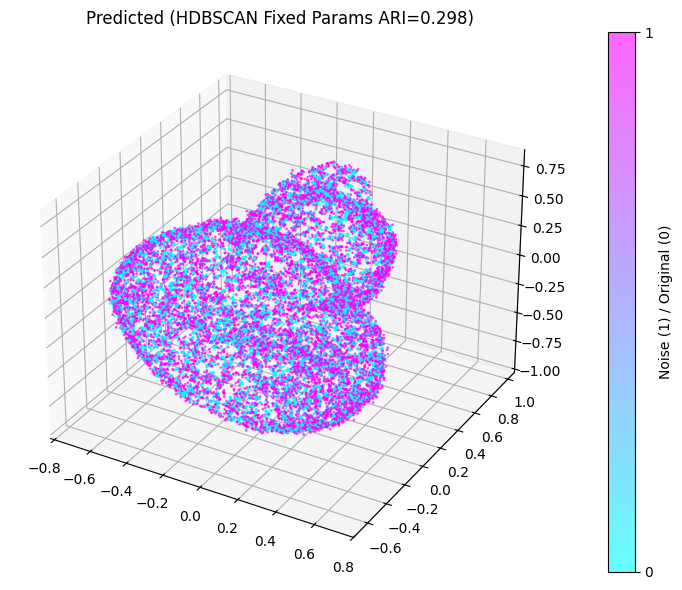


Noise points detected (HDBSCAN): 13329/30000
Actual noise points: 15000.0/30000


In [17]:
if __name__ == "__main__":
    model_name = "duck" 
    points, true_labels = load_noisy_model(model_name, noise_level=1)
    
    optimal_k_for_features = 10
    optimal_hdbscan_min_cluster_size = 3
    use_pca_for_final_run = False

    pred_labels_hdbscan, applied_params, ari_hdbscan, other_metrics_hdbscan = \
        detect_noise_b_hdbscan_no_opt(points, true_labels, 
                                     use_pca=use_pca_for_final_run, 
                                     k_neighbors_for_features=optimal_k_for_features,
                                     hdbscan_min_cluster_size=optimal_hdbscan_min_cluster_size)
    
    print(f"\nModel: {model_name} (HDBSCAN Optimized - Fixed Params)")
    print(f"Applied Params: {applied_params}")
    print(f"ARI Score: {ari_hdbscan:.3f}")
    print(f"Noise Precision: {other_metrics_hdbscan['precision_noise']:.3f}")
    print(f"Noise Recall: {other_metrics_hdbscan['recall_noise']:.3f}")
    print(f"Noise F1-Score: {other_metrics_hdbscan['f1_score_noise']:.3f}")
    
    plot_results(points, true_labels, "Ground Truth")
    plot_results(points, pred_labels_hdbscan, f"Predicted (HDBSCAN Fixed Params ARI={ari_hdbscan:.3f})")
    
    print(f"\nNoise points detected (HDBSCAN): {np.sum(pred_labels_hdbscan)}/{len(points)}")
    print(f"Actual noise points: {np.sum(true_labels)}/{len(points)}")